<div align="center">
    
<br>

# FINE-GRAINED EMOTIONAL CONTROL OF TEXT-TO-SPEECH 

### LEARNING TO RANK INTER- AND INTRA-CLASS EMOTION INTENSITIES

Shijun Wang, Jón Guðnason, Damian Borth

**ICASSP 2023**

<br>

---

<br>

</div>

In [ ]:
##############################################
# 1. Paths
##############################################
DATA_PATH           = '/workspace/data/EmoV-DB'
CORPUS_PATH         = '/workspace/montreal_forced_aligner/corpus'
TEXTGRID_PATH       = '/workspace/montreal_forced_aligner/aligned'


##############################################
# 2. Preprocessing
##############################################
NOISE_SYMBOL        = ' [noise] '
SPEAKERS            = ['bea', 'jenie', 'josh', 'sam']
EMOTIONS            = ['neutral', 'amused', 'angry', 'disgusted', 'sleepy']
SIL_PHONES          = ['sil', 'spn', 'sp', '']


##############################################
# 3. Audio (optimized for vocoder)
##############################################
SAMPLING_RATE       = 16000
HOP_LENGTH          = 256
WIN_LENGTH          = 1024
N_FFT               = 1024
N_MELS              = 80
F_MIN               = 0.0
F_MAX               = 8000.0

In [ ]:
import os
import tgt
import glob
import tqdm
import torch
import scipy
import librosa
import torchaudio
import numpy as np
import pyworld as pw

from text import _clean_text
from speechbrain.lobes.models.FastSpeech2 import mel_spectogram

**1. Preprocessing**



In [ ]:
audio_id_to_transcript = {}

with open(os.path.join(DATA_PATH, 'cmuarctic.data')) as f:
    for line in f.readlines():
        audio_id, transcript = line[2:-2].split('\"')[:2]

        audio_id = audio_id.strip()
        transcript = transcript.strip()

        if audio_id.startswith('arctic_b'):
            continue
        
        audio_id = audio_id[-4:]
        transcript = NOISE_SYMBOL + _clean_text(transcript, ['english_cleaners']) + NOISE_SYMBOL

        audio_id_to_transcript[audio_id] = transcript.strip()

/workspace/emo_rank_tts/text/__init__.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'
/workspace/emo_rank_tts/text/__init__.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'


In [ ]:
for speaker in tqdm.tqdm(SPEAKERS):
    for emotion in EMOTIONS:

        # check the path existence: josh has only three emotions
        spk_emo_path = os.path.join(DATA_PATH, speaker, emotion)
        if not os.path.exists(spk_emo_path):
            continue
        
        # resample and create .lab file
        for wav_path in glob.glob(os.path.join(spk_emo_path, '*.wav')):

            y, sr = librosa.load(wav_path, sr=SAMPLING_RATE)

            audio_id = os.path.basename(wav_path)[:-4]
            transcript = audio_id_to_transcript[audio_id]

            os.makedirs(os.path.join(CORPUS_PATH, speaker), exist_ok=True)

            tgt_path = os.path.join(CORPUS_PATH, speaker, f'{emotion}_{audio_id}')
            scipy.io.wavfile.write(tgt_path + '.wav', sr, y)

            with open(tgt_path + '.lab', 'w') as f:
                f.write(transcript + '\n')


100%|██████████| 4/4 [02:39<00:00, 39.76s/it]


In [ ]:
# download speech dictionary
wget -O /workspace/montreal_forced_aligner/librispeech-lexicon.txt https://openslr.trmal.net/resources/11/librispeech-lexicon.txt 

# prepare environment for montreal forced aligner
conda create -n aligner -c conda-forge montreal-forced-aligner -y

# **important** please make sure to select `aligner` environment
mfa model download acoustic english_us_arpa
mfa validate /workspace/montreal_forced_aligner/corpus /workspace/montreal_forced_aligner/librispeech-lexicon.txt english_us_arpa
mfa align /workspace/montreal_forced_aligner/corpus /workspace/montreal_forced_aligner/librispeech-lexicon.txt english_us_arpa /workspace/montreal_forced_aligner/aligned

In [101]:
def process_textgrid(textgrid_file):

    phones = []
    durations = []
    speech_start_time = 0.0
    speech_end_time = 0.0
    end_idx = 0

    tg = tgt.io.read_textgrid(textgrid_file, include_empty_intervals=True)
    tier = tg.get_tier_by_name('phones')

    for t in tier._objects:
        
        s, e, p = t.start_time, t.end_time, t.text

        if len(phones) == 0:
            if p in SIL_PHONES:
                continue
            speech_start_time = s

        if p not in SIL_PHONES:
            phones.append(p)
            speech_end_time = e
            end_idx = len(phones)
        else:
            phones.append('spn')

        durations.append(
            int(
                np.round(e * SAMPLING_RATE / HOP_LENGTH) -
                np.round(s * SAMPLING_RATE / HOP_LENGTH)
            )
        )

    phones = phones[:end_idx]
    durations = durations[:end_idx]

    return phones, durations, speech_start_time, speech_end_time


def trim_audio(y, start_time, end_time):
    start_idx = int(np.round(start_time * SAMPLING_RATE))
    end_idx = int(np.round(end_time * SAMPLING_RATE))

    y = y[start_idx:end_idx].astype(np.float32)
    return y


def get_pitch(y):
    y = y.astype(np.float64)
    f0, t = pw.dio(y, SAMPLING_RATE, frame_period=HOP_LENGTH / SAMPLING_RATE * 1000)
    f0 = pw.stonemask(y, f0, t, SAMPLING_RATE)
   
    return f0


def get_mel(y):
    y = torch.FloatTensor(y)
    mel, energy = mel_spectogram(
        audio=y,
        sample_rate=SAMPLING_RATE,
        hop_length=HOP_LENGTH,
        win_length=WIN_LENGTH,
        n_mels=N_MELS,
        n_fft=N_FFT,
        f_min=F_MIN,
        f_max=F_MAX,
        power=1,
        normalized=False,
        min_max_energy_norm=True,
        norm="slaney",
        mel_scale="slaney",
        compression=True
    )
    return mel, energy

In [ ]:
for audio_path in tqdm.tqdm(glob.glob(os.path.join(CORPUS_PATH, '*', '*.wav'))):

    textgrid_path = audio_path.replace('corpus', 'aligned').replace('.wav', '.TextGrid')
    transcript_path = audio_path.replace('.wav', '.lab')

    # check the path existence
    if not os.path.exists(textgrid_path):
        continue

    phones, durations, speech_start_time, speech_end_time = process_textgrid(textgrid_path)

    if speech_start_time >= speech_end_time:
        print(f"Invalid start/end: {audio_path}")

    # trim audio
    y, sr = librosa.load(audio_path, sr=None)
    y = trim_audio(y, speech_start_time, speech_end_time)

    # transcript
    with open(transcript_path, 'r') as f:
        transcript = f.read().strip().replace(NOISE_SYMBOL, '')

    # pitch
    pitch = get_pitch(y)
    if np.sum(pitch != 0) <= 1:
        print(f"Invalid pitch: {audio_path}")
        continue
    pitch = pitch[:sum(durations)]
    
    # melspectrogram, energy
    mel, energy = get_mel(y)
    mel = mel[:, :sum(durations)]
    energy = energy[:sum(durations)]


 61%|██████▏   | 4226/6888 [01:53<01:10, 37.94it/s]

Invalid pitch: /workspace/montreal_forced_aligner/corpus/josh/sleepy_0054.wav


 71%|███████   | 4905/6888 [02:15<01:05, 30.40it/s]

In [ ]:
import torchaudio
from speechbrain.inference.vocoders import HIFIGAN
from speechbrain.lobes.models.FastSpeech2 import mel_spectogram

# Load a pretrained HIFIGAN Vocoder
hifi_gan = HIFIGAN.from_hparams(source="speechbrain/tts-hifigan-libritts-16kHz", savedir="pretrained_models/tts-hifigan-libritts-16kHz")

# Load an audio file (an example file can be found in this repository)
# Ensure that the audio signal is sampled at 16000 Hz; refer to the provided link for a 22050 Hz Vocoder.
signal, rate = torchaudio.load('/workspace/montreal_forced_aligner/corpus/bea/amused_0001.wav')

# Ensure the audio is sigle channel
signal = signal[0].squeeze()

torchaudio.save('/workspace/waveform.wav', signal.unsqueeze(0), 16000)

# Compute the mel spectrogram.
# IMPORTANT: Use these specific parameters to match the Vocoder's training settings for optimal results.
spectrogram, _ = mel_spectogram(
    audio=signal.squeeze(),
    sample_rate=SAM,
    hop_length=256,
    win_length=1024,
    n_mels=80,
    n_fft=1024,
    f_min=0.0,
    f_max=8000.0,
    power=1,
    normalized=False,
    min_max_energy_norm=True,
    norm="slaney",
    mel_scale="slaney",
    compression=True
)

# Convert the spectrogram to waveform
waveforms = hifi_gan.decode_batch(spectrogram)

# Save the reconstructed audio as a waveform
torchaudio.save('/workspace/waveform_reconstructed.wav', waveforms.squeeze(1), 16000)

# If everything is set up correctly, the original and reconstructed audio should be nearly indistinguishable


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


torch.Size([202])
[0.5416914, 0.5416914, 0.5416914, 0.5416914, 0.5416914, 0.5416914, 0.5416914, 0.14790855, 0.14790855, 0.14790855, 0.14790855, 0.14790855, 0.14790855, 0.14790855, 0.14790855, 0.14790855, 0.14790855, 0.14790855, 0.14790855, 0.14790855, 0.14790855, 0.14790855, 0.5040103, 0.5040103, 0.5040103, 0.5040103, 0.5040103, 0.5040103, 0.5040103, 0.079116836, 0.25308183, 0.25308183, 0.25308183, 0.12266219, 0.12266219, 0.12266219, 0.12266219, 0.12266219, 0.12266219, 0.019508459, 0.019508459, 0.44131967, 0.44131967, 0.44131967, 0.44131967, 0.12963003, 0.12963003, 0.12963003, 0.12963003, 0.12963003, 0.12963003, 0.12963003, 0.12963003, 0.5186791, 0.5186791, 0.5186791, 0.5186791, 0.5186791, 0.5186791, 0.5186791, 0.5186791, 0.5186791, 0.3566997, 0.3566997, 0.3566997, 0.3566997, 0.3566997, 0.10625207, 0.10625207, 0.10625207, 0.10625207, 0.2098932, 0.2098932, 0.2098932, 0.2098932, 0.07438505, 0.07438505, 0.07438505, 0.07438505, 0.07438505, 0.07438505, 0.07438505, 0.07438505, 0.23484078, 0.

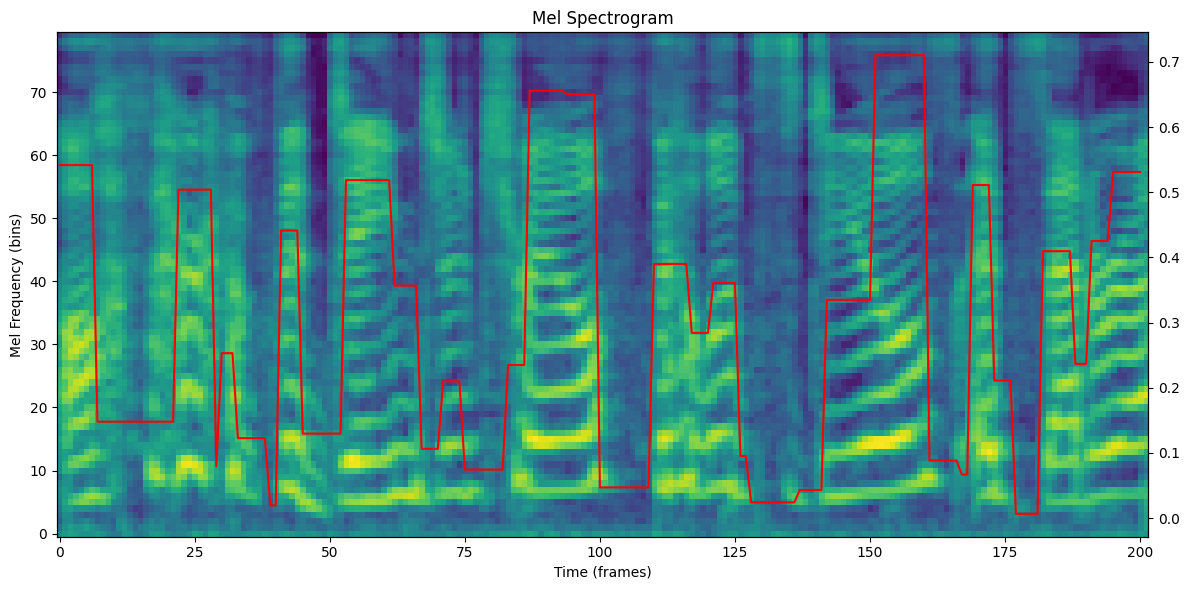

In [91]:
import torch
from scipy.interpolate import interp1d
from speechbrain.lobes.models.FastSpeech2 import mel_spectogram

audio_path = '/workspace/montreal_forced_aligner/corpus/bea/amused_0001.wav'
textgrid_path = '/workspace/montreal_forced_aligner/aligned/bea/amused_0001.TextGrid'

phones, durations, speech_start_time, speech_end_time = process_textgrid(textgrid_path)

y, sr = librosa.load(audio_path, sr=None)
y = y[int(speech_start_time * SAMPLING_RATE):int(speech_end_time * SAMPLING_RATE)]

# melspectrogram & energy
signal = torch.FloatTensor(y)
mel, energy = mel_spectogram(
    audio=signal,
    sample_rate=16000,
    hop_length=256,
    win_length=1024,
    n_mels=80,
    n_fft=1024,
    f_min=0.0,
    f_max=8000.0,
    power=1,
    normalized=False,
    min_max_energy_norm=True,
    norm="slaney",
    mel_scale="slaney",
    compression=True
)



# compute fundmaental frequency (pitch)
_f0, t = pw.dio(
    y.astype(np.float64),
    fs=SAMPLING_RATE,
    frame_period=HOP_LENGTH / SAMPLING_RATE * 1000
    )
pitch = pw.stonemask(y.astype(np.float64), _f0, t, fs=SAMPLING_RATE)
pitch = pitch[:sum(durations)]


interp = True
if interp == True:

    # perform linear interpolation
    nonzero_ids = np.where(pitch != 0)[0]
    interp_fn = interp1d(
        nonzero_ids,
        pitch[nonzero_ids],
        fill_value=(pitch[nonzero_ids[0]], pitch[nonzero_ids[-1]]),
        bounds_error=False,
    )
    pitch = interp_fn(np.arange(0, len(pitch)))

# Phoneme-level average
pos = 0
for i, d in enumerate(durations):
    if d > 0:
        pitch[i] = np.mean(pitch[pos : pos + d])
    else:
        pitch[i] = 0
    pos += d
pitch = pitch[: len(durations)]

print(energy.shape)

energy_phoneme_averaging = True
energy = energy.numpy()
if energy_phoneme_averaging:
    # Phoneme-level average
    pos = 0
    for i, d in enumerate(durations):
        if d > 0:
            energy[i] = np.mean(energy[pos : pos + d])
        else:
            energy[i] = 0
        pos += d
    energy = energy[: len(durations)]

expanded_energy = []
for i, d in enumerate(durations):
    expanded_energy.extend([energy[i]] * d)

print(expanded_energy)

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()
ax2.plot(expanded_energy, label='Energy', color='r')
ax1.imshow(mel, aspect='auto', origin='lower')
ax1.set_title('Mel Spectrogram')
ax1.set_xlabel('Time (frames)')
ax1.set_ylabel('Mel Frequency (bins)')
plt.tight_layout()
plt.show()

In [84]:
energy

tensor([8.4191e-02, 3.4855e-01, 6.7178e-01, 7.2996e-01, 6.9916e-01, 7.0660e-01,
        5.5161e-01, 2.7921e-01, 1.7264e-01, 1.4043e-01, 1.3889e-01, 1.1712e-01,
        4.9488e-02, 2.0190e-02, 1.4568e-02, 9.3800e-03, 7.1407e-02, 2.9555e-01,
        3.5279e-01, 2.3628e-01, 1.6659e-01, 1.5408e-01, 3.9291e-01, 7.7187e-01,
        7.7042e-01, 7.0388e-01, 5.2791e-01, 2.3057e-01, 1.3052e-01, 7.9117e-02,
        3.9600e-02, 2.1690e-01, 5.0274e-01, 4.1044e-01, 1.6731e-01, 8.6060e-02,
        4.7924e-02, 1.7997e-02, 6.2371e-03, 8.3477e-03, 3.0669e-02, 2.1196e-01,
        4.8023e-01, 5.5895e-01, 5.1414e-01, 3.2040e-01, 2.3406e-01, 1.4829e-01,
        8.3234e-02, 3.7516e-02, 1.8883e-02, 4.4803e-02, 1.4985e-01, 5.5896e-01,
        9.8314e-01, 8.8060e-01, 5.5472e-01, 4.4552e-01, 3.5847e-01, 2.7926e-01,
        2.8584e-01, 3.2162e-01, 3.3489e-01, 3.2279e-01, 3.5796e-01, 4.0738e-01,
        3.6049e-01, 1.7451e-01, 8.6199e-02, 6.3391e-02, 1.0091e-01, 1.8740e-01,
        2.4667e-01, 2.2137e-01, 1.8413e-